* [Adam](https://ruder.io/optimizing-gradient-descent/index.html#adam)
* [DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
* [Netflix vs GAN](https://www.youtube.com/watch?v=dyRvbFhknRc)
* [GANHacks](https://github.com/soumith/ganhacks)
* [GAN Awesome Applications](https://github.com/nashory/gans-awesome-applications)
* [Conv Arithmetic](https://github.com/vdumoulin/conv_arithmetic)
* [Transp Conv](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision as tv

In [ ]:
ds = tv.datasets.MNIST('/content/drive/My Drive/Aulas/', download=True)

In [ ]:
data, labels = ds.data[:], ds.targets[:]

In [ ]:
def make_image_from_tensor(x, nrows=8):
  grid = tv.utils.make_grid((x+1)/2., nrow=nrows)
  pil_image = tv.transforms.ToPILImage()(grid).resize((256*2, 256))
  return pil_image

# Dataset

In [ ]:
class MyDataset(Dataset):

  tfms = tv.transforms.Compose([
      tv.transforms.ToPILImage(),
      tv.transforms.Resize((64, 64)),
      tv.transforms.ToTensor()
  ])

  def __init__(self, x, y):
    self.x, self.y = x, y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    x = self.x[idx]
    y = self.y[idx]
    x = self.tfms(x)
    x = 2 * x - 1 # normalizar para melhorar o resultado da rede
    return x, y

In [ ]:
train_size = 48_000
ds_train = MyDataset(data[:train_size], labels[:train_size])
ds_valid = MyDataset(data[train_size:], labels[train_size:])

In [ ]:
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=4)
dl_valid = DataLoader(ds_valid, batch_size=32, shuffle=False, num_workers=4)

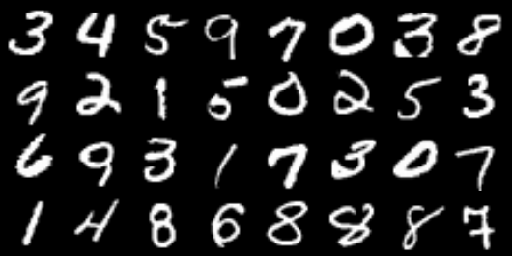

In [ ]:
x, y = next(iter(dl_train))
make_image_from_tensor(x)

In [ ]:
x.max(), x.min()

(tensor(1.), tensor(-1.))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Generator

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_size, drop=0.):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_size, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh() # (-1, 1)
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
noise_size = 100

In [ ]:
fixed_noise_vector = torch.randn((50, noise_size, 1, 1))

In [ ]:
generator = Generator(noise_size)
generator.apply(weights_init).to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.0, inplace=False)
    (4): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout2d(p=0.0, inplace=False)
    (8): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout2d(p=0.0, inplace=False)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(in

torch.Size([50, 1, 64, 64])


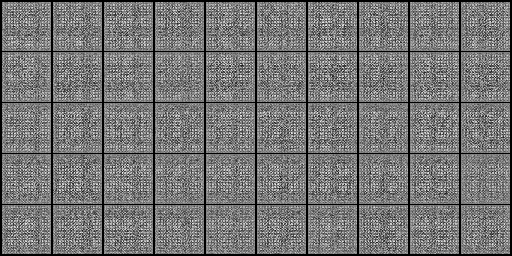

In [ ]:
with torch.no_grad():
  fake_image = generator(fixed_noise_vector.to(device))
print(fake_image.shape)
make_image_from_tensor(fake_image.cpu(), 10)

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 11, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).squeeze()

In [ ]:
discriminator = Discriminator()
discriminator.apply(weights_init).to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 11, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [ ]:
with torch.no_grad():
    out = discriminator(fake_image.to(device))
out

tensor([[-1.1825e+00,  5.3880e-01,  1.3982e+00,  1.1423e+00,  1.5211e-01,
         -1.1350e+00, -3.3113e-01,  1.0513e+00, -1.5417e+00, -1.0586e+00,
         -1.8231e-01],
        [ 5.1316e-02,  1.1629e+00,  9.4936e-01,  1.9402e+00, -1.2939e+00,
         -1.5906e+00,  1.2513e+00, -1.0675e+00, -1.0668e+00,  1.2914e+00,
          3.8439e-01],
        [ 6.1430e-01,  1.0670e+00, -8.1407e-01,  7.2625e-01,  1.9123e-02,
         -5.0751e-01,  1.1538e+00, -1.4502e+00, -1.4368e+00, -2.1049e+00,
         -6.2739e-01],
        [ 2.1949e+00, -3.5495e-01,  1.4494e-01, -8.7133e-02,  3.5293e-02,
         -2.6746e+00, -6.6094e-01, -5.3554e-01, -1.7398e+00, -2.4037e+00,
          4.1899e-01],
        [ 4.2983e-01,  1.2897e+00,  1.8901e+00,  1.7094e+00, -1.9349e-01,
          3.5649e-01,  2.0378e+00, -1.1419e+00, -2.3115e+00, -8.8217e-01,
         -3.7538e-01],
        [ 2.1090e-02,  1.2122e+00,  5.6424e-01,  3.2319e-01, -2.4055e-01,
          9.8807e-01, -3.1310e-01, -4.0485e-01, -1.8823e+00, -2.0667e+0

In [ ]:
with torch.no_grad():
    out = discriminator(x.to(device))
out

tensor([[ 0.3794,  1.1004,  2.5867,  1.4815, -1.1733, -0.3267,  1.2502,  2.4334,
         -2.5970, -0.4634,  1.0619],
        [-0.6919,  0.1542,  2.0849,  1.4475,  0.8589,  0.6152,  1.3451, -0.8599,
         -0.1345,  0.6937, -1.7134],
        [ 1.1645,  0.6146,  1.1429,  0.8517,  0.4935,  0.0571,  1.7126, -0.4840,
         -0.5241, -0.8280,  0.9542],
        [-0.1457,  0.2462,  1.0575, -1.0336,  1.7971,  0.6739,  1.0814, -0.2137,
         -1.5705,  0.0551, -0.9182],
        [ 1.8595,  0.3324,  1.9396, -0.1204,  0.1639,  1.5945,  0.8762,  0.3278,
         -1.9712,  1.1693,  0.0989],
        [ 1.1822, -1.1166,  1.8471, -1.0590, -0.5586,  0.6800,  1.0341,  0.4221,
         -0.8918,  1.9936,  1.8560],
        [-0.5181, -0.3337,  2.4137,  0.4912, -1.0309,  0.5668,  0.2895,  1.3001,
         -0.0905, -0.4727,  0.0260],
        [ 1.4467, -0.9825,  2.1503,  1.4929, -0.3087, -0.5379, -0.4731,  0.6603,
          0.5214, -0.2758,  0.7615],
        [ 2.3242, -1.2308,  2.3105,  1.7102, -0.1182,  0

# Train params

In [ ]:
lr = 2e-4
num_epochs = 50
betas = (0.5, 0.999)

loss_bce = nn.BCELoss()

loss_ce = nn.CrossEntropyLoss()

optim_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optim_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

real_label = 1
fake_label = 0

generated_images = []

In [ ]:
for ep in tqdm(range(num_epochs)):
  discriminator.train()
  generator.train()
  for x, y in tqdm(dl_train, leave=False, total=len(dl_train)):

    # preparing
    x = x.to(device)
    y = y.to(device)
    N = x.shape[0]
    
    noise = torch.randn(N, noise_size, 1, 1).to(device)

    ## Training the discriminator
    discriminator.zero_grad()
    real_labels = torch.tensor(N * [real_label], dtype=torch.float).to(device)
    fake_labels = torch.tensor(N * [fake_label], dtype=torch.float).to(device)

    disc_real_out = discriminator(x) # classifies the real images

    loss_real = loss_bce(disc_real_out[:,0].sigmoid(), real_labels)

    loss_ce_true = loss_ce(disc_real_out[:,1:], y)

    loss_total_real = loss_ce_true + loss_real

    loss_total_real.backward()
    
    fake_image = generator(noise) # generates fake images
    disc_fake_out = discriminator(fake_image.detach()) # classifies the fake images
    loss_fake = loss_bce(disc_fake_out[:,0].sigmoid(), fake_labels)

    loss_fake.backward()

    optim_discriminator.step()

    #################################
    # print('x:')
    # print(x.shape)
    # print(x)

    # print('y:')
    # print(y.shape)
    # print(y)

    # print('disc_real_out:')
    # print(disc_real_out.shape)
    # print(disc_real_out)

    # print('maiores que 0.5 (VERDADEIRO)')
    # array = disc_real_out>0.5
    # print(array)
    #################################

    ## Training the generator
    generator.zero_grad()
    disc_out = discriminator(fake_image) # classifies the fake images
    loss_gen = loss_bce(disc_out[:,0].sigmoid(), real_labels) # invert labels to maximize loss function
    loss_gen.backward()
    optim_generator.step()

  ## Metrics
  print(f'Epoch [{ep+1}/{num_epochs}]')
  print(f'Total Loss Disc. {loss_real.item()+loss_fake.item()}')
  print(f'Mean of Disc real prob {disc_real_out[:,0].sigmoid().mean().item()}')
  print(f'Mean of Disc fake prob {disc_fake_out[:,0].sigmoid().mean().item()} (before step)')
  print(f'Mean of Disc fake prob {disc_out[:,0].sigmoid().mean().item()} (after step)')
  generated_images.append(fake_image.detach().cpu())

  ## Saving the image from the fixed noise
  with torch.no_grad():
    # generator.eval()
    fake_image = generator(fixed_noise_vector.to(device))
  pil_image = make_image_from_tensor(fake_image.cpu(), 10)
  pil_image.save(f'/content/drive/My Drive/EA999/FakeMNIST/{ep+1}.jpg')

Epoch [1/50]
Total Loss Disc. 0.3240508884191513
Mean of Disc real prob 0.8231934905052185
Mean of Disc fake prob 0.0943322479724884 (before step)
Mean of Disc fake prob 0.09478680044412613 (after step)


Epoch [2/50]
Total Loss Disc. 0.4580572284758091
Mean of Disc real prob 0.6964194774627686
Mean of Disc fake prob 0.04684949666261673 (before step)
Mean of Disc fake prob 0.29225677251815796 (after step)


Epoch [3/50]
Total Loss Disc. 0.0798858143389225
Mean of Disc real prob 0.9559616446495056
Mean of Disc fake prob 0.03304353356361389 (before step)
Mean of Disc fake prob 0.031576089560985565 (after step)


Epoch [4/50]
Total Loss Disc. 0.2624652497470379
Mean of Disc real prob 0.946108341217041
Mean of Disc fake prob 0.16231025755405426 (before step)
Mean of Disc fake prob 0.00888843834400177 (after step)


Epoch [5/50]
Total Loss Disc. 0.4682261273264885
Mean of Disc real prob 0.7519232630729675
Mean of Disc fake prob 0.094655342400074 (before step)
Mean of Disc fake prob 0.0688345804810524 (after step)


Epoch [6/50]
Total Loss Disc. 0.695083984057419
Mean of Disc real prob 0.5649840831756592
Mean of Disc fake prob 0.0005265887011773884 (before step)
Mean of Disc fake prob 0.2273823320865631 (after step)


Epoch [7/50]
Total Loss Disc. 0.25512094981968403
Mean of Disc real prob 0.7948165535926819
Mean of Disc fake prob 0.00131168810185045 (before step)
Mean of Disc fake prob 0.020537693053483963 (after step)


KeyboardInterrupt: ignored

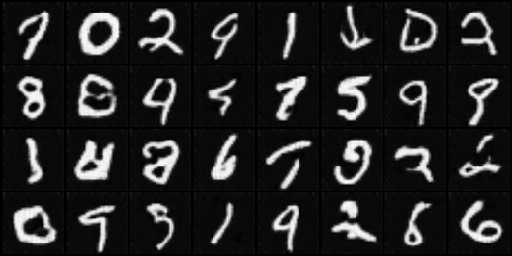

In [ ]:
len(generated_images)
make_image_from_tensor(generated_images[-1])

In [ ]:
range(10)

In [ ]:
from time import sleep

In [ ]:
def mygen(_list):
  j = 1
  for i in range(len(_list)):
    if i == 1:
      j = 2
    sleep(1)
    yield _list[j]  

In [ ]:
a = [1, 2, 3, 4]

In [ ]:
for v in tqdm(mygen(a), total=len(a), leave=False, desc='Training...'):
  print(v)